<a href="https://colab.research.google.com/github/prasoonvarshney/advanced-nlp-f22-hw2/blob/main/src/notebooks/NER_Model_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Token Sequence Labeling

In [1]:
!nvidia-smi

Thu Oct 20 04:30:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup
Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the followin line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from transformers import RobertaForTokenClassification, RobertaTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification

from datasets import load_dataset

from tqdm.notebook import tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Spacy Visualizations

In [4]:
!pip install -U spacy
!pip install spacy[transformers]
!python -m spacy download en_core_web_lg 
!python -m spacy download en_core_web_trf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 4.7 MB 18.9 MB/s 
     |████████████████████████████████| 1.1 MB 44.7 MB/s 
     |████████████████████████████████| 6.6 MB 55.0 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.1
    Uninstalling tokenizers-0.13.1:
      Successfully uninstalled tokenizers-0.13.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.23.1
    Uninstalling transformers-4.23.1:
      Successfully uninstalled transformers-4.23.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.1 kB/s 
✔ Download and installation successful
You can now load the pack

In [5]:
import spacy
from spacy import displacy

def print_entities(pipeline, text):
    # Create a document 
    document = pipeline(text)
    # Entity text & label extraction
    for entity in document.ents:
        print(entity.text + '->', entity.label_)
        
        
def visualize_entities(pipeline, text):
    # Create a document 
    document = pipeline(text)
    # Show entities in pretty manner
    displacy.render(document, jupyter=True, style='ent')

In [6]:
nlp_spacy_lg = spacy.load("en_core_web_lg")
nlp_spacy_roberta = spacy.load("en_core_web_trf")

text = "On Monday, Apple kicked off its annual Worldwide Developers Conference with a first-of-its-kind special event held at Apple Park that welcomed developers, students, and media to a viewing of the keynote, Platforms State of the Union, and an unveiling of the all-new Apple Developer Center. Attendees also got a first look at the completely redesigned MacBook Air and the updated 13-inch MacBook Pro powered by the breakthrough M2 chip; new features coming to iOS 16, iPadOS 16, macOS Ventura, and watchOS 9; and the latest innovative technologies that enable developers to build their best apps on the App Store. For a complete rundown of this week’s 175+ developer sessions with Apple experts and all WWDC22 events, visit developer.apple.com."

In [7]:
visualize_entities(nlp_spacy_lg, text)

In [8]:
visualize_entities(nlp_spacy_roberta, text)

## Our Dataloader

In [ ]:
from datasets import Dataset

class CoNLLDataset(Dataset):

    def __init__(self, text):
        self.text, self.labels = parse
        self.labels = labels
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):

class TextDataset(Dataset):
    def __init__(self, text_list):
        self.text = text_list
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        return self.text[idx]
    


IndentationError: ignored

## CoNLL Data Exploration

In [6]:
from datasets import load_dataset
dataset = load_dataset("conll2003")

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [8]:
dataset["train"][0]["tokens"]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [9]:
dataset["train"][0]["ner_tags"]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [10]:
ner_feature = dataset["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [11]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [12]:
words = dataset["train"][0]["tokens"]
labels = dataset["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

EU    rejects German call to boycott British lamb . 
B-ORG O       B-MISC O    O  O       B-MISC  O    O 


In [13]:
dataset["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [14]:
labels = dataset['train'].features['ner_tags'].feature
label_names = labels.names
num_labels = labels.num_classes
print(f"Labels: {label_names}, Number of labels: {num_labels}")

# get the NER labels and create two dictionaries for accessing their ids
label2id = {k: labels.str2int(k) for k in label_names}
id2label = {v: k for k, v in label2id.items()}

Labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], Number of labels: 9


In [15]:
id2label

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [16]:
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

## Evaluation Metrics

In [17]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import evaluate
import numpy as np

metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [19]:
labels = dataset["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [20]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

In [21]:
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

## Change the model to initialize here

In [22]:
# model_checkpoint = "roberta-base"
# tokenizer = RobertaTokenizerFast.from_pretrained(model_checkpoint, add_prefix_space=True)
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
# model = RobertaForTokenClassification.from_pretrained(model_checkpoint, id2label=id2label, label2id=label2id, num_labels=num_labels)
# model.to(device)

In [34]:
# model_checkpoint = "bert-base-cased"
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
# model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, id2label=id2label, label2id=label2id, num_labels=num_labels)
# model.to(device)

In [23]:
model_checkpoint = "emilys/twitter-roberta-base-dec2021-CoNLL"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, id2label=id2label, label2id=label2id, num_labels=num_labels)
model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

## Label Alignment - TODO: Check if we need this - 
Prasoon tested: YES needed!! Pre-aligning is speeding up training almost 10x :)


In [24]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX  # Pra: this is actually fine
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [25]:
inputs = tokenizer(dataset["train"][0]["tokens"], truncation=True, is_split_into_words=True)
print(inputs.tokens())
labels = dataset["train"][0]["ner_tags"]
print(labels)
word_ids = inputs.word_ids()
print(word_ids)
# print(labels)
print(align_labels_with_tokens(labels, word_ids))

['<s>', 'ĠEU', 'Ġrejects', 'ĠGerman', 'Ġcall', 'Ġto', 'Ġboycott', 'ĠBritish', 'Ġlamb', 'Ġ.', '</s>']
[3, 0, 7, 0, 0, 0, 7, 0, 0]
[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]


In [26]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [27]:
# Temporary error handling cell; TODO: remove
# for sentence in tqdm(dataset["test"]): 
#     try: 
#         inputs = tokenizer(sentence["tokens"], is_split_into_words=True)
#         align_labels_with_tokens(sentence["ner_tags"], inputs.word_ids())
#     except Exception as e: 
#         print(f"Exception occurred: {e}")
#         inputs = tokenizer(sentence["tokens"], is_split_into_words=True)
#         print(inputs.tokens())
#         print(inputs.word_ids())
#         print(align_labels_with_tokens(sentence["ner_tags"], inputs.word_ids()))

In [28]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

  0%|          | 0/15 [00:00<?, ?ba/s]

In [29]:
tokenized_dataset["train"][0]

{'input_ids': [0, 1281, 24020, 1859, 486, 7, 13978, 1089, 17988, 479, 2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]}

In [30]:
batch = data_collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100]])

In [31]:
for i in range(2):
    print(tokenized_dataset["train"][i]["labels"])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]
[-100, 1, 2, -100]


## Model Training Pipeline with CoNLL dataset

### Hyperparameters

In [32]:
# Hyperparams
BATCH_SIZE = 8
LR = 1e-5
N_EPOCHS = 1
WEIGHT_DECAY = 1e-4

### Setup Data

In [33]:
train_data = DataLoader(tokenized_dataset['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_data = DataLoader(tokenized_dataset['validation'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_data = DataLoader(tokenized_dataset['test'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

### Huggingface Transformers Trainer

In [37]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    num_train_epochs=N_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [38]:
print(model_checkpoint)

emilys/twitter-roberta-base-dec2021-CoNLL


In [39]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14041
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1756


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.004600,0.067380,0.945663,0.957758,0.951672,0.989215


***** Running Evaluation *****
  Num examples = 3250
  Batch size = 8
Saving model checkpoint to bert-finetuned-ner/checkpoint-1756
Configuration saved in bert-finetuned-ner/checkpoint-1756/config.json
Model weights saved in bert-finetuned-ner/checkpoint-1756/pytorch_model.bin
tokenizer config file saved in bert-finetuned-ner/checkpoint-1756/tokenizer_config.json
Special tokens file saved in bert-finetuned-ner/checkpoint-1756/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1756, training_loss=0.006539336573290119, metrics={'train_runtime': 213.7298, 'train_samples_per_second': 65.695, 'train_steps_per_second': 8.216, 'total_flos': 299191471781616.0, 'train_loss': 0.006539336573290119, 'epoch': 1.0})

### Custom Trainer

In [74]:
optimizer = optim.AdamW(params=model.parameters(), lr=LR)

In [108]:
def train(train_data, val_data): 
    model.train()
    train_loss = []

    for epoch in tqdm(range(N_EPOCHS)):
        current_loss = 0
        for i, batch in enumerate(tqdm(train_data)):
            batch = { k: v.to(device) for k, v in batch.items() }
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()
            current_loss += loss.item()
            if i % 8 == 0 and i > 0:
                optimizer.step()
                optimizer.zero_grad()
                train_loss.append(current_loss / 8)
                current_loss = 0
        # update the model one last time for this epoch
        optimizer.step()
        optimizer.zero_grad()

    return train_loss

In [79]:
train_loss = train(train_data, val_data)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1756 [00:00<?, ?it/s]

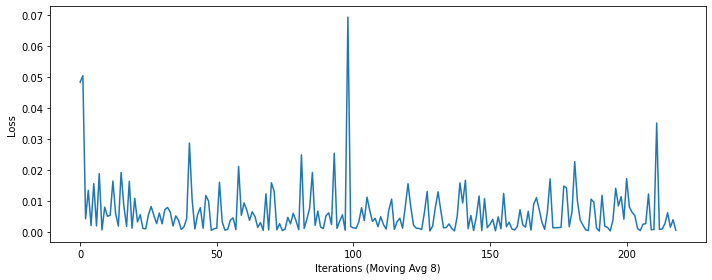

In [80]:
fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations (Moving Avg 8)')
fig.tight_layout()
plt.show()

## Model Evaluation

### Helper functions

In [34]:
def evaluate(val_data):
    model.eval()
    confusion = torch.zeros(num_labels+1, num_labels+1)
    for i, batch in enumerate(tqdm(val_data)):
        with torch.no_grad():
            batch = { k: v.to(device) for k, v in batch.items() }
            outputs = model(**batch)
                
        s_lengths = batch['attention_mask'].sum(dim=1)
        for idx, length in enumerate(s_lengths):
            true_values = batch['labels'][idx][:length]
            pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
            for true, pred in zip(true_values, pred_values):
                # insert padding tokens as label 10
                true_label = true.item()
                pred_label = pred.item()
                if true_label == -100 or pred_label == -100:
                    continue
                confusion[true_label][pred_label] += 1

    return confusion.numpy().astype(int)

In [35]:
import copy
def display_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(10, 10))

    confusion_matrix_normalized = copy.deepcopy(confusion_matrix).astype(float)
    # Normalize by dividing every row by its sum
    for i in range(num_labels):
        confusion_matrix_normalized[i] = confusion_matrix_normalized[i] / confusion_matrix_normalized[i].sum()
    ax.matshow(confusion_matrix_normalized)

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='x-large')

    labels = list(label2id.keys())
    ids = np.arange(len(labels))

    ax.set_ylabel('True Labels', fontsize='x-large')
    ax.set_xlabel('Pred Labels', fontsize='x-large')

    ax.set_xticks(ids)
    ax.set_xticklabels(labels)

    ax.set_yticks(ids)
    ax.set_yticklabels(labels)

    fig.tight_layout()
    plt.show()

### Confusion matrices

1. bert-base-cased (no finetuning)

  0%|          | 0/407 [00:00<?, ?it/s]

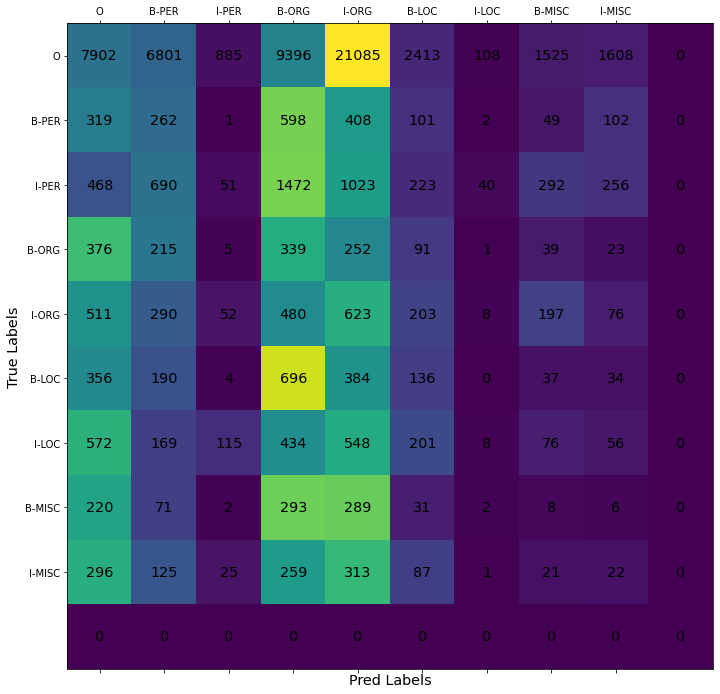

In [36]:
# bert-base-cased

confusion_matrix = evaluate(val_data)
display_confusion_matrix(confusion_matrix)

2. bert-base-cased (trained for 1 epoch on CoNLL using Trainer class)

  0%|          | 0/407 [00:00<?, ?it/s]

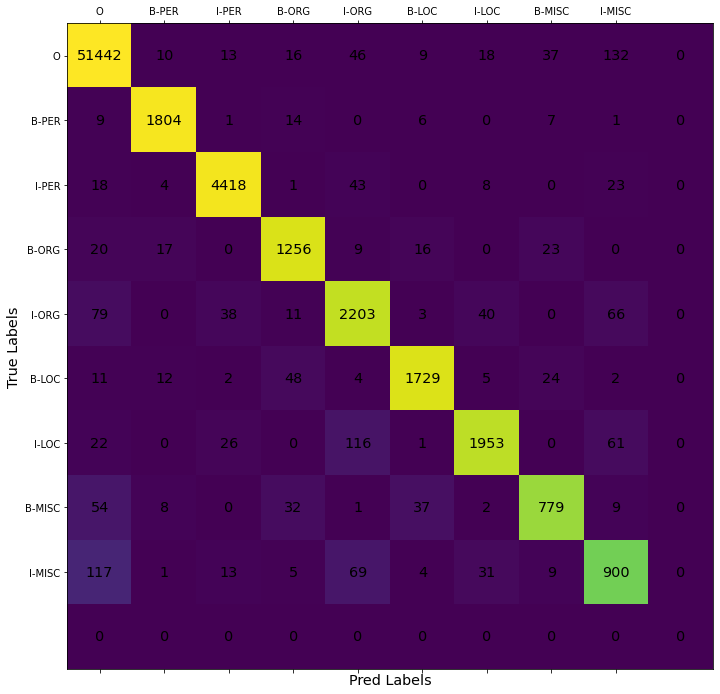

In [40]:
# bert-base-cased

confusion_matrix = evaluate(val_data)
display_confusion_matrix(confusion_matrix)

3. roberta-base (no finetuning)

  0%|          | 0/407 [00:00<?, ?it/s]

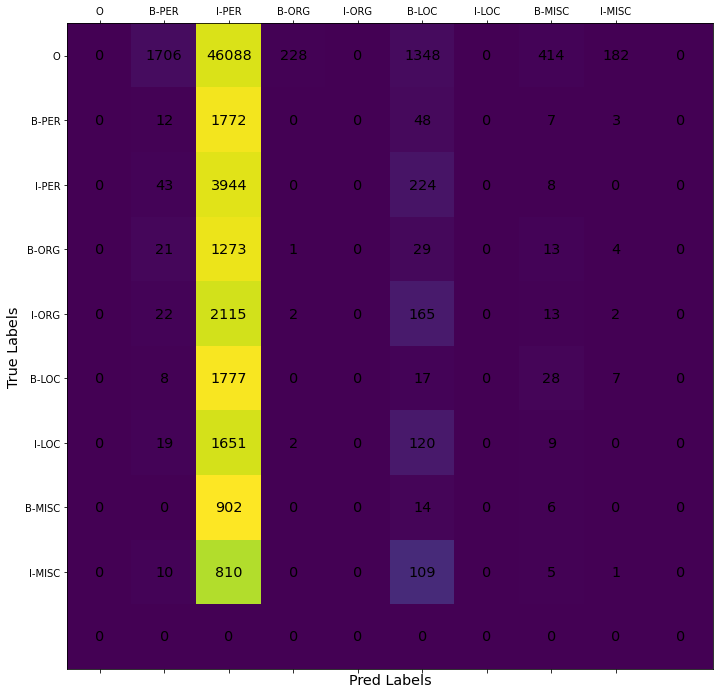

In [50]:
# roberta-base

confusion_matrix = evaluate(val_data)
display_confusion_matrix(confusion_matrix)

4. roberta-base (trained for 1 epoch on CoNLL using Trainer class)

  0%|          | 0/407 [00:00<?, ?it/s]

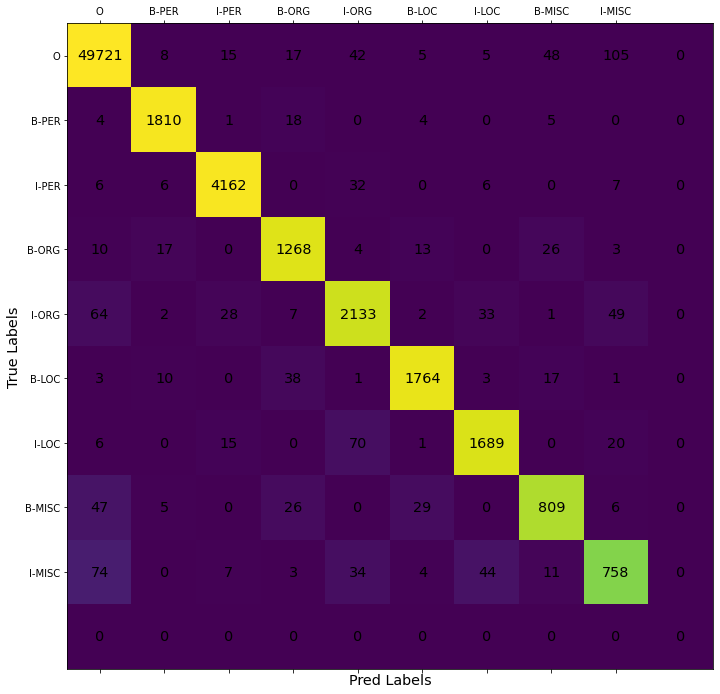

In [55]:
# roberta-base

confusion_matrix = evaluate(val_data)
display_confusion_matrix(confusion_matrix)

5. emilys/twitter-roberta-base-dec2021-CoNLL (no further finetuning)

  0%|          | 0/407 [00:00<?, ?it/s]

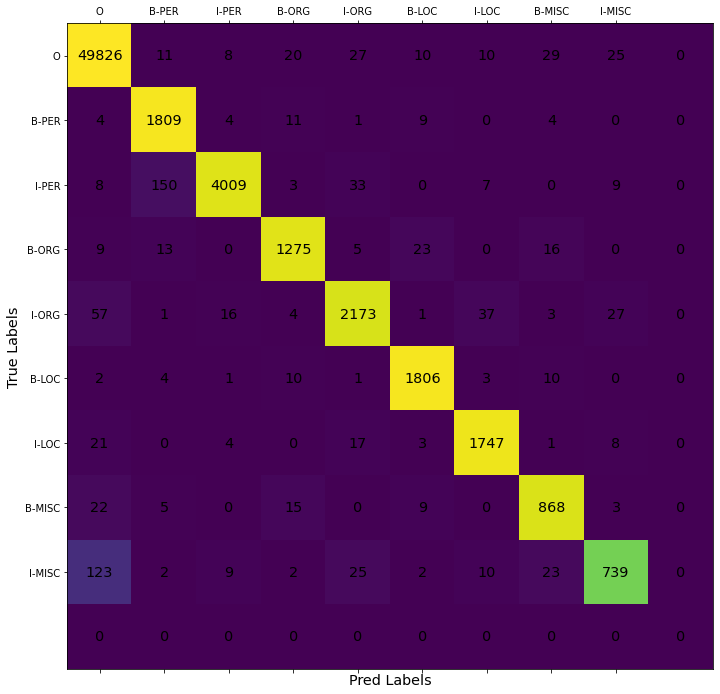

In [36]:
# emilys/twitter-roberta-base-dec2021-CoNLL

confusion_matrix = evaluate(val_data)
display_confusion_matrix(confusion_matrix)

6. emilys/twitter-roberta-base-dec2021-CoNLL (trained for 1 epoch on CoNLL using Trainer class)

  0%|          | 0/407 [00:00<?, ?it/s]

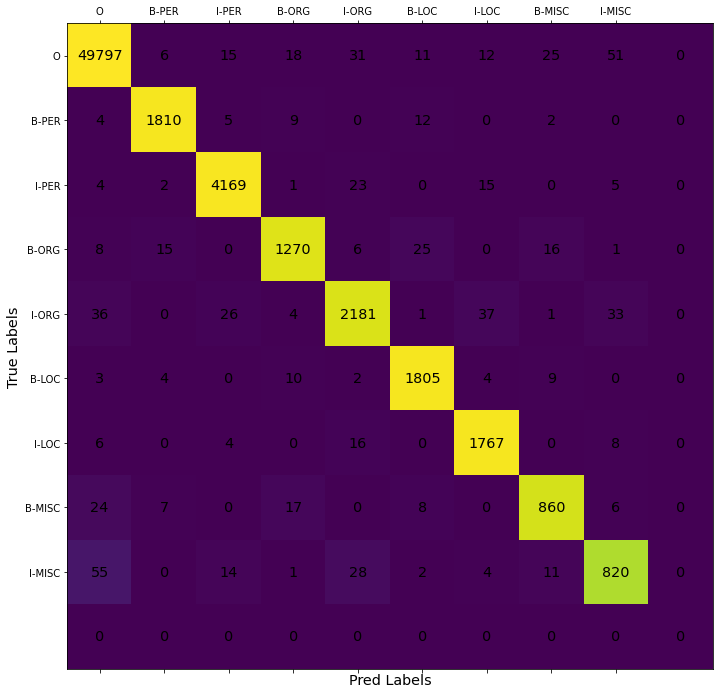

In [40]:
# emilys/twitter-roberta-base-dec2021-CoNLL

confusion_matrix = evaluate(val_data)
display_confusion_matrix(confusion_matrix)

## Another accelerator module (ignore for now)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_dataset["validation"], collate_fn=data_collator, batch_size=8
)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-ner-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'sgugger/bert-finetuned-ner-accelerate'

In [ ]:
output_dir = "bert-finetuned-ner-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In [ ]:
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/bert-finetuned-ner"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

[{'entity_group': 'PER', 'score': 0.9988506, 'word': 'Sylvain', 'start': 11, 'end': 18},
 {'entity_group': 'ORG', 'score': 0.9647625, 'word': 'Hugging Face', 'start': 33, 'end': 45},
 {'entity_group': 'LOC', 'score': 0.9986118, 'word': 'Brooklyn', 'start': 49, 'end': 57}]